In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import sys
from io import StringIO
old_stdout = sys.stdout
sys.stdout = StringIO()
os.system('pip install --upgrade protobuf==3.20.* -q')
sys.stdout = old_stdout

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

print("libraries imported successfully")
print(f"TensorFlow: {tf.__version__} | Pandas: {pd.__version__}")

libraries imported successfully
TensorFlow: 2.18.0 | Pandas: 2.2.3


In [4]:
import pandas.core.indexes as indexes

sys.modules['pandas.indexes'] = indexes
sys.modules['pandas.indexes.base'] = indexes.base
sys.modules['pandas.indexes.range'] = indexes.range

def load_wafer_data(filepath):
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_wafer_data('/kaggle/input/wm811k-wafer-map/LSWMD.pkl')

print(f"Dataset loaded successfully")
print(f"Total samples: {len(df):,}")
print(f"Columns: {list(df.columns)}")

Dataset loaded successfully
Total samples: 811,457
Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']


In [6]:
df_clean = df[(df['waferMap'].notna()) & (df['failureType'].notna()) & (df['failureType'] != 'none')]

print(f"Cleaned dataset: {len(df_clean):,} samples")
print(f"Removed: {len(df) - len(df_clean):,} samples (nulls + 'none' class)")

sample_map = df_clean.iloc[0]['waferMap']
print(f"\nSample waferMap shape: {np.array(sample_map).shape}")
print(f"Sample waferMap type: {type(sample_map)}")

Cleaned dataset: 25,519 samples
Removed: 785,938 samples (nulls + 'none' class)

Sample waferMap shape: (45, 48)
Sample waferMap type: <class 'numpy.ndarray'>


Defect Class Distribution:
['Edge-Ring']    9680
['Edge-Loc']     5189
['Center']       4294
['Loc']          3593
['Scratch']      1193
['Random']        866
['Donut']         555
['Near-full']     149
Name: count, dtype: int64


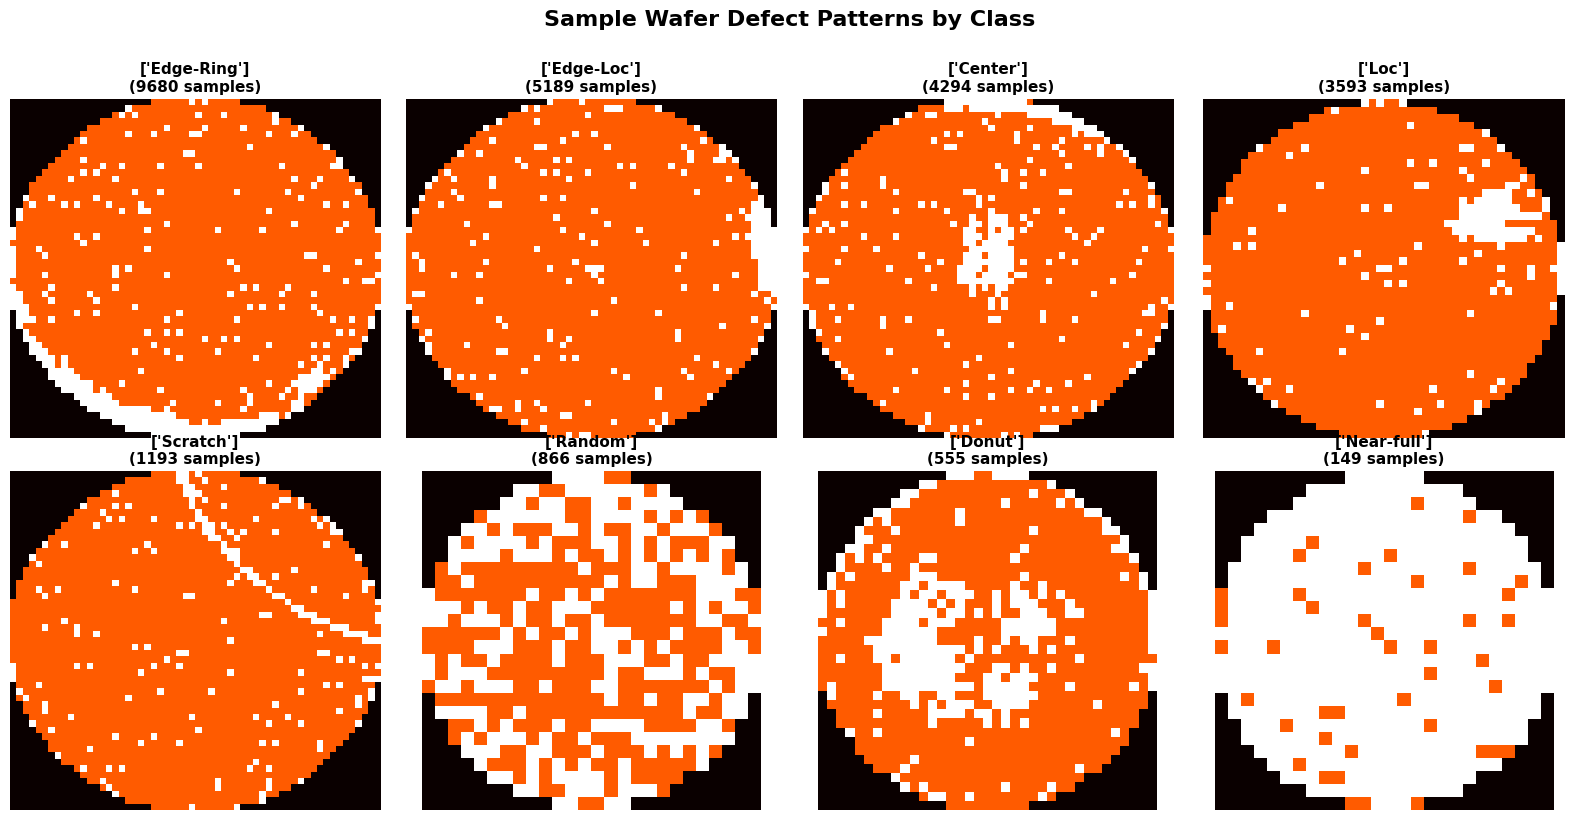

In [7]:
labels_raw = []
for ft in df_clean['failureType']:
    if isinstance(ft, np.ndarray):
        labels_raw.append(str(ft[0]) if len(ft) > 0 else 'unknown')
    else:
        labels_raw.append(str(ft))

df_clean['failureType_str'] = labels_raw

class_counts = pd.Series(labels_raw).value_counts()
print("Defect Class Distribution:")
print(class_counts)

unique_classes = class_counts.index[:8] 
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, defect_class in enumerate(unique_classes):
    sample = df_clean[df_clean['failureType_str'] == defect_class].iloc[0]
    wafer = np.array(sample['waferMap'])
    
    axes[idx].imshow(wafer, cmap='hot', interpolation='nearest')
    axes[idx].set_title(f'{defect_class}\n({class_counts[defect_class]} samples)', fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Sample Wafer Defect Patterns by Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/kaggle/working/sample_wafer_defects.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
def preprocess_wafermap(wafer_map, target_size=(64, 64)):
    arr = np.array(wafer_map, dtype=np.float32)
    if arr.max() > 0:
        arr = arr / arr.max()
    arr_resized = tf.image.resize(arr[..., np.newaxis], target_size).numpy()
    return arr_resized.squeeze()
n_samples = 50000
df_sample = df_clean.head(n_samples).reset_index(drop=True)

print(f"Processing {n_samples:,} wafer maps to 64x64...")
X = np.array([preprocess_wafermap(wm) for wm in df_sample['waferMap']])
X = X[..., np.newaxis]  

y = df_sample['failureType_str'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nPreprocessing complete")
print(f"X shape: {X.shape}")
print(f"y shape: {y_encoded.shape}")
print(f"Number of classes: {len(le.classes_)}")
print(f"Classes: {list(le.classes_)}")

Processing 50,000 wafer maps to 64x64...


I0000 00:00:1764712833.183151      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764712833.183781      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Preprocessing complete
X shape: (25519, 64, 64, 1)
y shape: (25519,)
Number of classes: 8
Classes: ["['Center']", "['Donut']", "['Edge-Loc']", "['Edge-Ring']", "['Loc']", "['Near-full']", "['Random']", "['Scratch']"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Data split complete")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Input shape: {X_train.shape[1:]}")
print(f"Classes in training set: {len(np.unique(y_train))}")

Data split complete
Training samples: 20,415
Test samples: 5,104
Input shape: (64, 64, 1)
Classes in training set: 8


In [10]:
def build_baseline_cnn(input_shape=(64, 64, 1), num_classes=8):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='Baseline_CNN')
    
    return model

baseline_model = build_baseline_cnn(input_shape=(64, 64, 1), num_classes=len(le.classes_))

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Baseline CNN Model Built")
baseline_model.summary()

Baseline CNN Model Built


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,552 (2.61 MB)

 Trainable params: 684,104 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
print("Training Baseline Model...")
print("="*60)

history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=8,
    batch_size=32,
    verbose=1
)
baseline_loss, baseline_acc = baseline_model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*60)
print("BASELINE MODEL RESULTS")
print("="*60)
print(f"Test Accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print(f"Test Loss: {baseline_loss:.4f}")
print("="*60)

Training Baseline Model...
Epoch 1/8


I0000 00:00:1764712952.980387     136 service.cc:148] XLA service 0x79fa28013510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764712952.981009     136 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764712952.981028     136 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764712953.364774     136 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4599 - loss: 2.0731

I0000 00:00:1764712956.871855     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


638/638 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.6932 - loss: 0.9006 - val_accuracy: 0.7968 - val_loss: 0.5653
Epoch 2/8
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8152 - loss: 0.5081 - val_accuracy: 0.8143 - val_loss: 0.5371
Epoch 3/8
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8474 - loss: 0.4079 - val_accuracy: 0.8558 - val_loss: 0.4197
Epoch 4/8
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8614 - loss: 0.3538 - val_accuracy: 0.8658 - val_loss: 0.4158
Epoch 5/8
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8797 - loss: 0.3070 - val_accuracy: 0.8147 - val_loss: 0.5877
Epoch 6/8
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8942 - loss: 0.2726 - val_accuracy: 0.8450 - val_loss: 0.5060
Epoch 7/8
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9085 - loss: 0.2329 - val_accuracy: 0.8409 - val_loss: 0.4663
Epoch 8/8
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9212 - loss: 0.2101 - val_accuracy: 0.8936 - val_loss:

# **A better Data augumentation and Improved CNN** - for improved accuracy

In [13]:
def build_improved_cnn(input_shape=(64, 64, 1), num_classes=8):
    model = keras.Sequential([
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='Improved_CNN')
    
    return model

improved_model = build_improved_cnn(input_shape=(64, 64, 1), num_classes=len(le.classes_))

improved_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Improved CNN Model Built (Deeper Architecture)")
improved_model.summary()

Improved CNN Model Built (Deeper Architecture)


Model: "Improved_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,418,664 (9.23 MB)

 Trainable params: 2,418,216 (9.22 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
print("Training Improved Model with Callbacks...")
print("="*60)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

history_improved = improved_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

improved_loss, improved_acc = improved_model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*60)
print("IMPROVED MODEL RESULTS")
print("="*60)
print(f"Test Accuracy: {improved_acc:.4f} ({improved_acc*100:.2f}%)")
print(f"Test Loss: {improved_loss:.4f}")
print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"Baseline:  {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print(f"Improved:  {improved_acc:.4f} ({improved_acc*100:.2f}%)")
print(f"Gain:      {(improved_acc - baseline_acc):.4f} ({(improved_acc - baseline_acc)*100:.2f}%)")
print("="*60)

Training Improved Model with Callbacks...
Epoch 1/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.6250 - loss: 1.2474 - val_accuracy: 0.1409 - val_loss: 3.4497 - learning_rate: 0.0010
Epoch 2/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7849 - loss: 0.6057 - val_accuracy: 0.5274 - val_loss: 1.3499 - learning_rate: 0.0010
Epoch 3/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8390 - loss: 0.4607 - val_accuracy: 0.8515 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 4/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8560 - loss: 0.3997 - val_accuracy: 0.8824 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 5/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8747 - loss: 0.3531 - val_accuracy: 0.8391 - val_loss: 0.5139 - learning_rate: 0.0010
Epoch 6/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8862 - loss: 0.3240 - val_accuracy: 0.8989 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 7/15
319/319 ━━━━━━━━━━━━━━━━━━━━

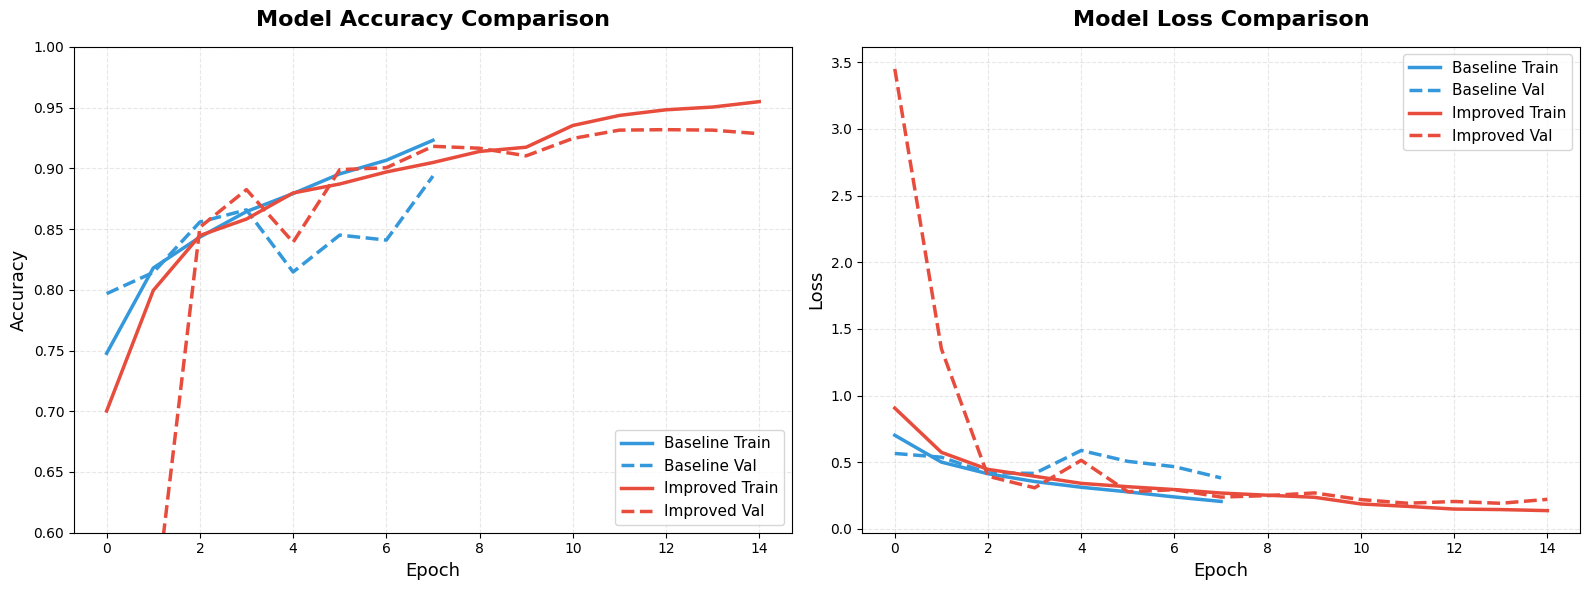

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(history_baseline.history['accuracy'], label='Baseline Train', linewidth=2.5, color='#3498db')
axes[0].plot(history_baseline.history['val_accuracy'], label='Baseline Val', linewidth=2.5, color='#3498db', linestyle='--')
axes[0].plot(history_improved.history['accuracy'], label='Improved Train', linewidth=2.5, color='#e74c3c')
axes[0].plot(history_improved.history['val_accuracy'], label='Improved Val', linewidth=2.5, color='#e74c3c', linestyle='--')
axes[0].set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Accuracy', fontsize=13)
axes[0].legend(fontsize=11, loc='lower right')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0.6, 1.0])

axes[1].plot(history_baseline.history['loss'], label='Baseline Train', linewidth=2.5, color='#3498db')
axes[1].plot(history_baseline.history['val_loss'], label='Baseline Val', linewidth=2.5, color='#3498db', linestyle='--')
axes[1].plot(history_improved.history['loss'], label='Improved Train', linewidth=2.5, color='#e74c3c')
axes[1].plot(history_improved.history['val_loss'], label='Improved Val', linewidth=2.5, color='#e74c3c', linestyle='--')
axes[1].set_title('Model Loss Comparison', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Loss', fontsize=13)
axes[1].legend(fontsize=11, loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('/kaggle/working/training_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

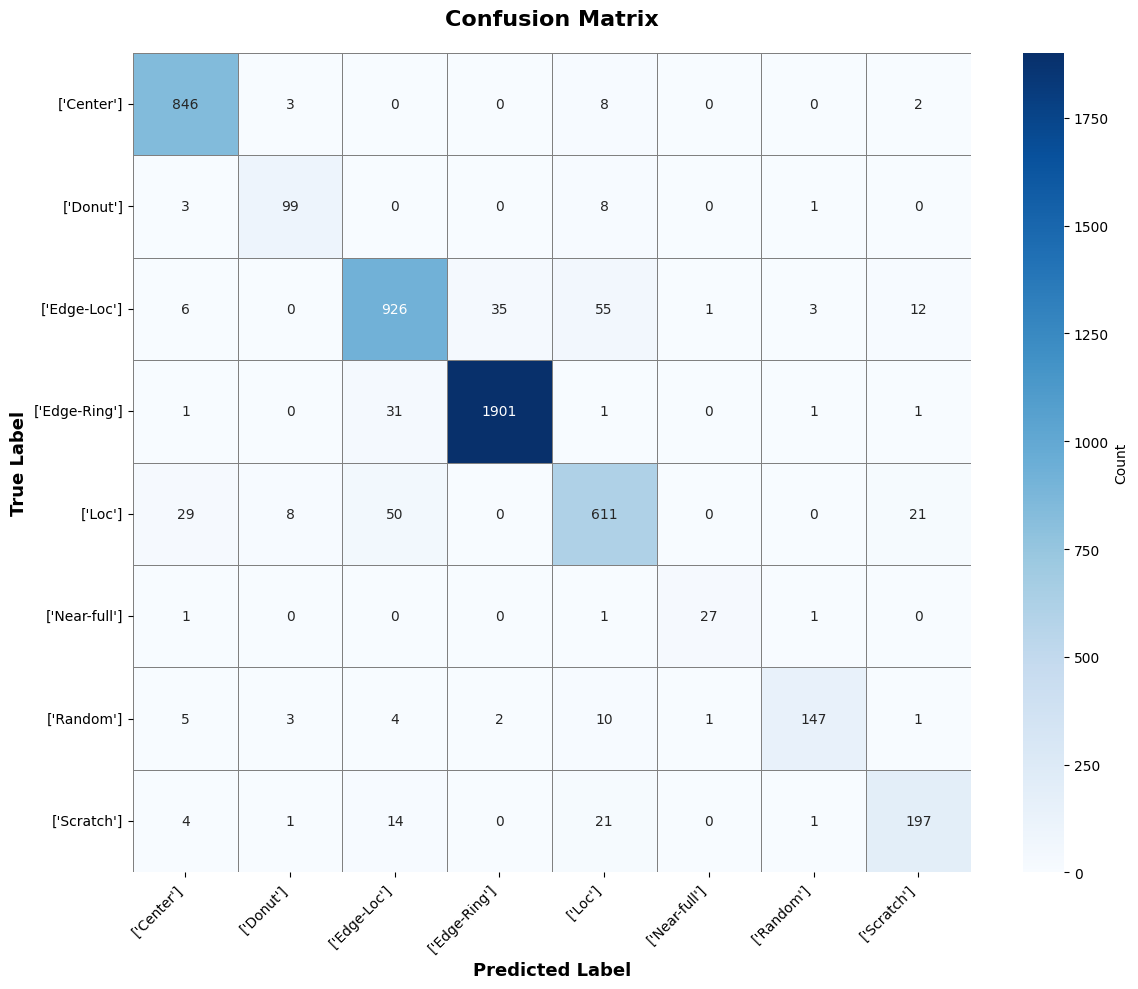


PER-CLASS PERFORMANCE
        Class  Precision  Recall  F1-Score  Support
   ['Center']     0.9453  0.9849    0.9647      859
    ['Donut']     0.8684  0.8919    0.8800      111
 ['Edge-Loc']     0.9034  0.8921    0.8977     1038
['Edge-Ring']     0.9809  0.9819    0.9814     1936
      ['Loc']     0.8545  0.8498    0.8522      719
['Near-full']     0.9310  0.9000    0.9153       30
   ['Random']     0.9545  0.8497    0.8991      173
  ['Scratch']     0.8419  0.8277    0.8347      238

OVERALL PERFORMANCE SUMMARY
             Metric  Score
           Accuracy 0.9314
Macro Avg Precision 0.9100
   Macro Avg Recall 0.8973
 Macro Avg F1-Score 0.9031


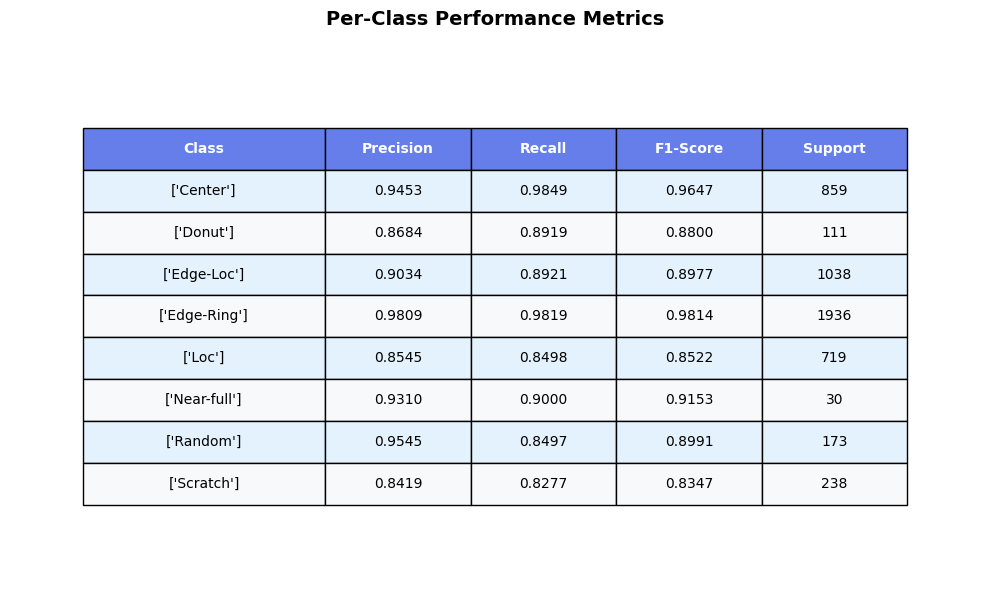

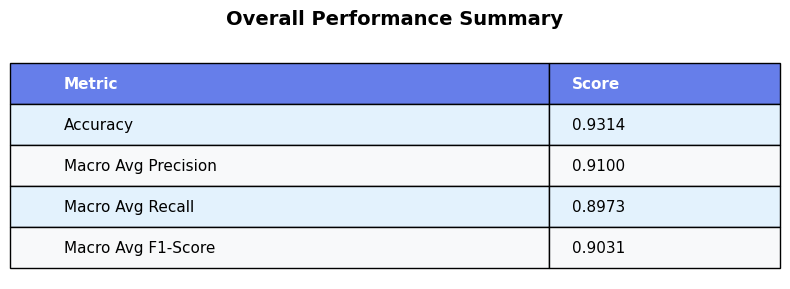

In [25]:
y_pred = improved_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes)

report_df = pd.DataFrame({
    'Class': le.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score'],
    'Score': [improved_acc, np.mean(precision), np.mean(recall), np.mean(f1)]
})

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE")
print("="*80)
print(report_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))

print("\n" + "="*80)
print("OVERALL PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*80)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

table_data = [['Class', 'Precision', 'Recall', 'F1-Score', 'Support']]
for _, row in report_df.iterrows():
    table_data.append([row['Class'], f"{row['Precision']:.4f}", f"{row['Recall']:.4f}", 
                       f"{row['F1-Score']:.4f}", str(int(row['Support']))])

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

for i in range(5):
    table[(0, i)].set_text_props(weight='bold', color='white')
    table[(0, i)].set_facecolor('#667eea')

for i in range(1, len(table_data)):
    color = '#f8f9fa' if i % 2 == 0 else '#e3f2fd'
    for j in range(5):
        table[(i, j)].set_facecolor(color)

plt.title('Per-Class Performance Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/kaggle/working/per_class_performance.png', dpi=150, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

table_data2 = [['Metric', 'Score']] + [[m, f'{s:.4f}'] for m, s in zip(summary_df['Metric'], summary_df['Score'])]

table2 = ax.table(cellText=table_data2, cellLoc='left', loc='center',
                colWidths=[0.7, 0.3])

table2.auto_set_font_size(False)
table2.set_fontsize(11)
table2.scale(1, 2.5)

for i in range(2):
    table2[(0, i)].set_text_props(weight='bold', color='white')
    table2[(0, i)].set_facecolor('#667eea')

for i in range(1, 5):
    color = '#f8f9fa' if i % 2 == 0 else '#e3f2fd'
    for j in range(2):
        table2[(i, j)].set_facecolor(color)

plt.title('Overall Performance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/kaggle/working/performance_summary_table.png', dpi=150, bbox_inches='tight')
plt.show()


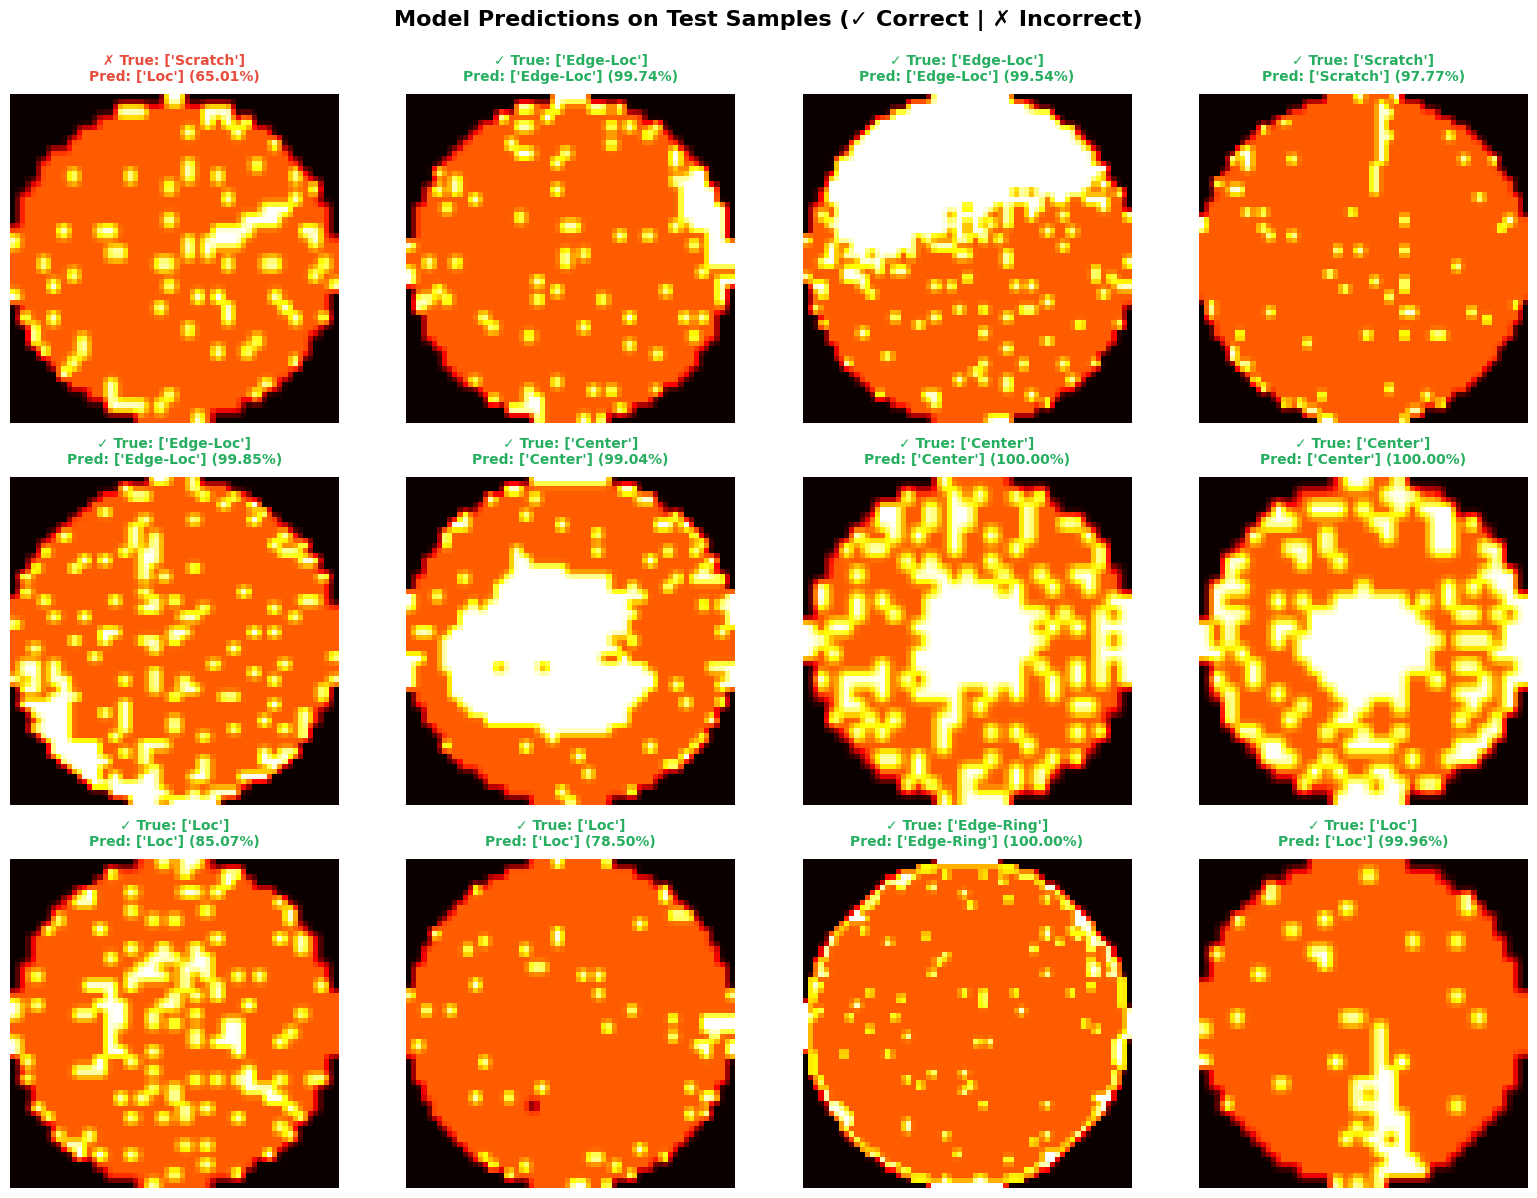


Sample predictions visualized
Accuracy on displayed samples: 91.67% (11/12)


In [26]:
np.random.seed(42)
n_samples = 12
random_indices = np.random.choice(len(X_test), n_samples, replace=False)

sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]
sample_preds = improved_model.predict(sample_images, verbose=0)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_pred_probs = np.max(sample_preds, axis=1)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx in range(n_samples):
    img = sample_images[idx].squeeze()
    true_label = le.classes_[sample_labels[idx]]
    pred_label = le.classes_[sample_pred_classes[idx]]
    confidence = sample_pred_probs[idx]
    
    is_correct = true_label == pred_label
    border_color = '#27ae60' if is_correct else '#e74c3c'
    title_symbol = '✓' if is_correct else '✗'
    
    axes[idx].imshow(img, cmap='hot', interpolation='nearest')
    axes[idx].set_title(f'{title_symbol} True: {true_label}\nPred: {pred_label} ({confidence:.2%})', 
                       fontsize=10, fontweight='bold', color=border_color, pad=10)
    axes[idx].axis('off')
    
    for spine in axes[idx].spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

plt.suptitle('Model Predictions on Test Samples (✓ Correct | ✗ Incorrect)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/kaggle/working/prediction_samples.png', dpi=150, bbox_inches='tight')
plt.show()

sample_accuracy = np.mean(sample_labels == sample_pred_classes)
print(f"\nSample predictions visualized")
print(f"Accuracy on displayed samples: {sample_accuracy:.2%} ({np.sum(sample_labels == sample_pred_classes)}/{n_samples})")

Model saved to /kaggle/working/wafer_cnn_improved.h5


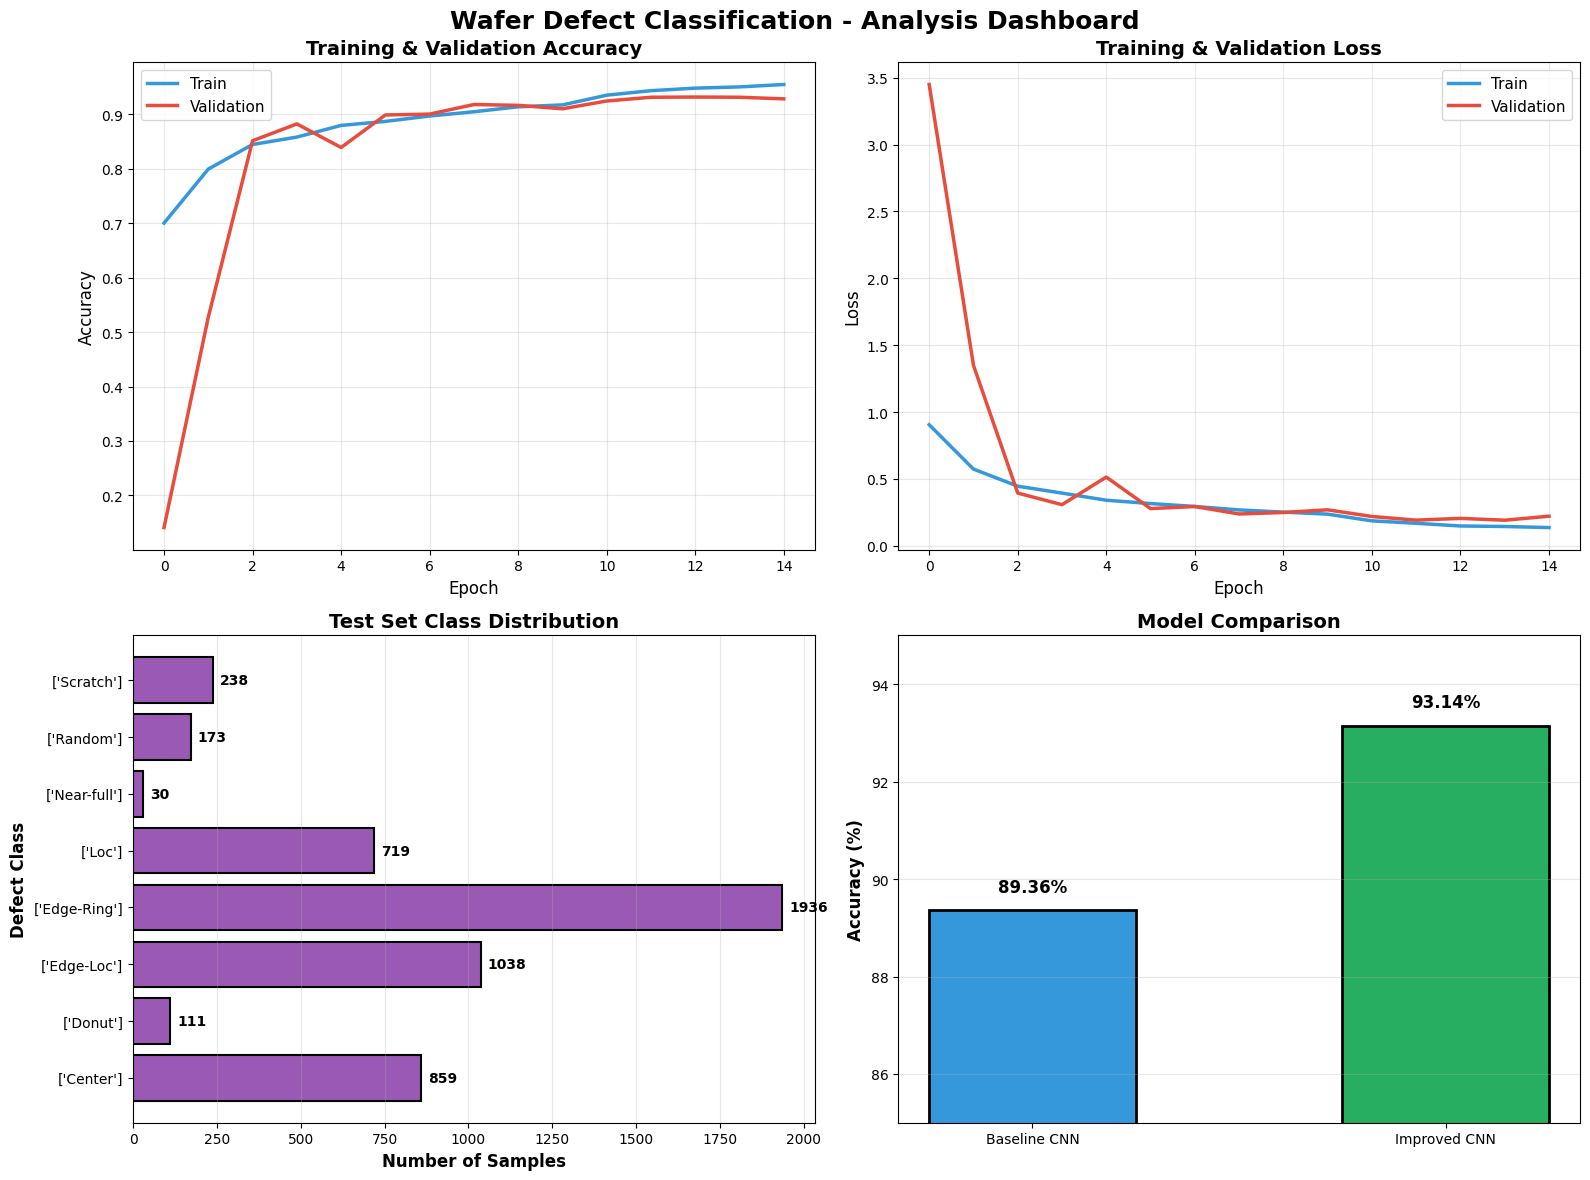

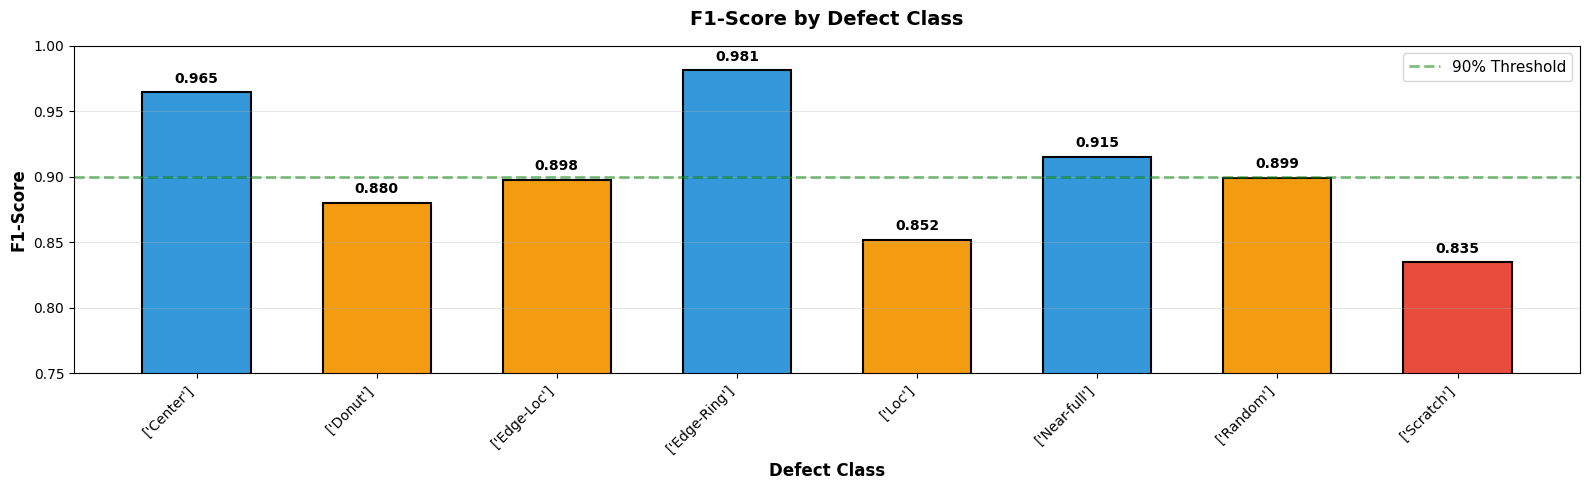

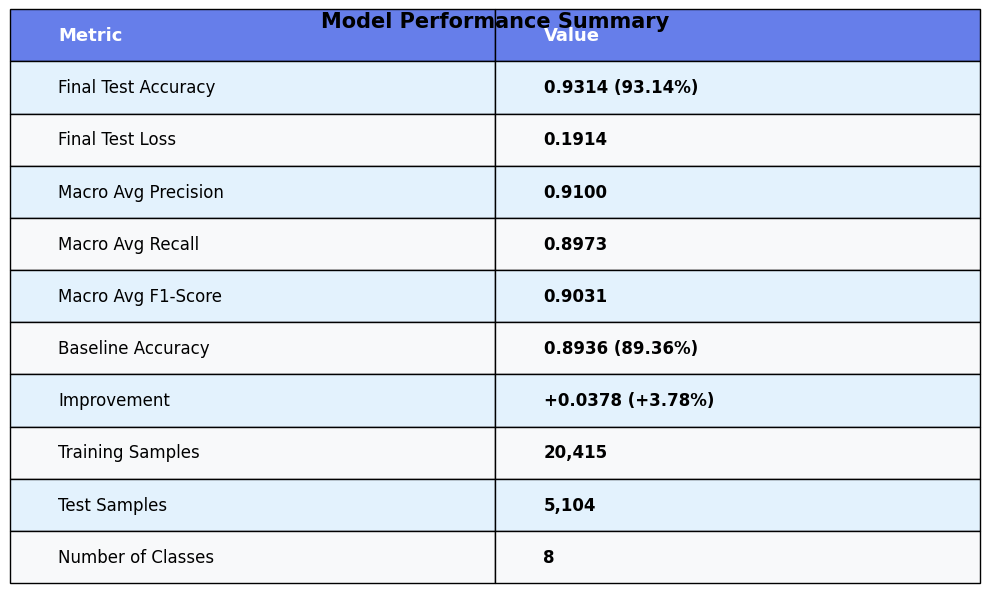

In [31]:
improved_model.save('/kaggle/working/wafer_cnn_improved.h5')
print("Model saved to /kaggle/working/wafer_cnn_improved.h5")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(history_improved.history['accuracy'], label='Train', linewidth=2.5, color='#3498db')
axes[0, 0].plot(history_improved.history['val_accuracy'], label='Validation', linewidth=2.5, color='#e74c3c')
axes[0, 0].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_improved.history['loss'], label='Train', linewidth=2.5, color='#3498db')
axes[0, 1].plot(history_improved.history['val_loss'], label='Validation', linewidth=2.5, color='#e74c3c')
axes[0, 1].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

class_support = [support[i] for i in range(len(le.classes_))]
axes[1, 0].barh(le.classes_, class_support, color='#9b59b6', edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Defect Class', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(class_support):
    axes[1, 0].text(v + 20, i, str(v), va='center', fontweight='bold', fontsize=10)

models = ['Baseline CNN', 'Improved CNN']
accuracies = [baseline_acc * 100, improved_acc * 100]
colors_comp = ['#3498db', '#27ae60']
bars = axes[1, 1].bar(models, accuracies, color=colors_comp, edgecolor='black', linewidth=2, width=0.5)
axes[1, 1].set_title('Model Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([85, 95])
axes[1, 1].grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('Wafer Defect Classification - Analysis Dashboard', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('/kaggle/working/dashboard_part1.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 5))
colors = ['#3498db' if score > 0.90 else '#e74c3c' if score < 0.85 else '#f39c12' for score in f1]
bars = plt.bar(le.classes_, f1, color=colors, edgecolor='black', linewidth=1.5, width=0.6)
plt.title('F1-Score by Defect Class', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Defect Class', fontweight='bold', fontsize=12)
plt.ylabel('F1-Score', fontweight='bold', fontsize=12)
plt.ylim([0.75, 1.0])
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0.90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='90% Threshold')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('/kaggle/working/f1_scores.png', dpi=150, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
summary_data = [
    ['Metric', 'Value'],
    ['Final Test Accuracy', f'{improved_acc:.4f} ({improved_acc*100:.2f}%)'],
    ['Final Test Loss', f'{improved_loss:.4f}'],
    ['Macro Avg Precision', f'{np.mean(precision):.4f}'],
    ['Macro Avg Recall', f'{np.mean(recall):.4f}'],
    ['Macro Avg F1-Score', f'{np.mean(f1):.4f}'],
    ['Baseline Accuracy', f'{baseline_acc:.4f} ({baseline_acc*100:.2f}%)'],
    ['Improvement', f'+{(improved_acc - baseline_acc):.4f} (+{(improved_acc - baseline_acc)*100:.2f}%)'],
    ['Training Samples', f'{len(X_train):,}'],
    ['Test Samples', f'{len(X_test):,}'],
    ['Number of Classes', f'{len(le.classes_)}']
]
table = ax.table(cellText=summary_data, cellLoc='left', loc='center', colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 3)
for i in range(2):
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=13)
    table[(0, i)].set_facecolor('#667eea')
for i in range(1, len(summary_data)):
    color = '#f8f9fa' if i % 2 == 0 else '#e3f2fd'
    for j in range(2):
        table[(i, j)].set_facecolor(color)
        if j == 1:
            table[(i, j)].set_text_props(weight='bold')
ax.set_title('Model Performance Summary', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/kaggle/working/performance_summary.png', dpi=150, bbox_inches='tight')
plt.show()